In [1]:
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from utils.utils import eval_dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
target = 'target'
data = df

In [3]:
model_ctgan = CTGANSynthesizer(epochs=1)
model_ctgan.fit(data)

Init CTGAN with differential privacy.  Target epsilon: 4
Epoch 1, Loss G: -0.0389, Loss D: -0.0141, Epsilon: 1.1379
Epoch 2, Loss G: -0.0341, Loss D: -0.0596, Epsilon: 1.6057
Epoch 3, Loss G:  0.0051, Loss D: -0.0792, Epsilon: 1.9682
Epoch 4, Loss G: -0.0077, Loss D: -0.1536, Epsilon: 2.2780
Epoch 5, Loss G: -0.0124, Loss D: -0.2390, Epsilon: 2.5529
Epoch 6, Loss G: -0.0377, Loss D: -0.2727, Epsilon: 2.8073
Epoch 7, Loss G: -0.0118, Loss D: -0.3411, Epsilon: 3.0354
Epoch 8, Loss G: -0.0543, Loss D: -0.3973, Epsilon: 3.2574
Epoch 9, Loss G: -0.1050, Loss D: -0.4908, Epsilon: 3.4590
Epoch 10, Loss G: -0.1695, Loss D: -0.5778, Epsilon: 3.6605
Epoch 11, Loss G: -0.2279, Loss D: -0.6343, Epsilon: 3.8481
Epoch 12, Loss G: -0.3276, Loss D: -0.6893, Epsilon: 4.0235


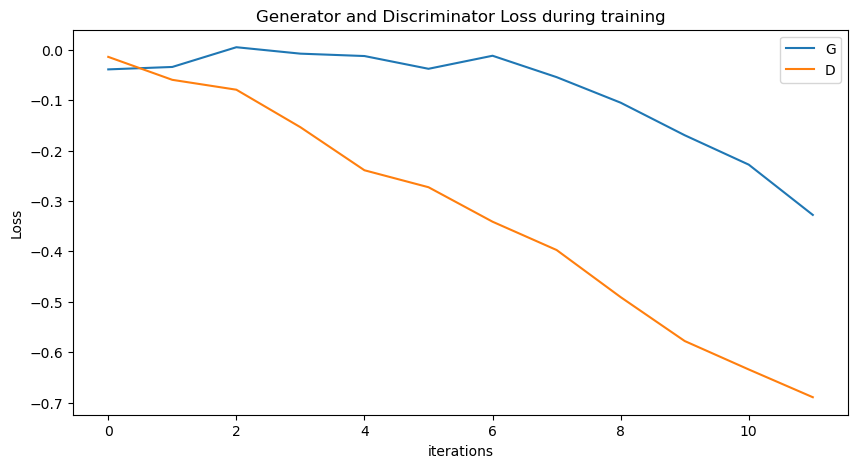

In [8]:
dpctgan = DPCTGANSynthesizer(verbose=True,
                            epochs=1,
                            clip_coeff=0.1,
                            sigma=4,
                            target_epsilon=4,
                            target_delta=1e-5
                            )
dpctgan.fit(data)
dpctgan.plot_losses()


In [27]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

def eval_fidelity(X_train, y_train, X_test, X_syn_train, X_syn_test, y_syn_train):
    learners = [(AdaBoostClassifier(n_estimators=50))]

    history = dict()

    for i in range(len(learners)):
        model_real = learners[i]
        model_real.fit(X_train, y_train)

        model_fake = learners[i]
        model_fake.fit(X_syn_train, y_syn_train)

        #first letter is data where it trained, second is data where it tested
        rr_pred = []
        fr_pred = []
        ff_pred = []
        rf_pred = []

        for j in range (len(X_test)):
            print(X_test.iloc[j])
            rr_pred.append(model_real.predict(X_test.iloc[j]))
            fr_pred.append(model_fake.predict(X_test.iloc[j]))
            rf_pred.append(model_fake.predict(X_syn_test.iloc[j]))
            ff_pred.append(model_fake.predict(X_syn_test.iloc[j]))
        
    return rr_pred, fr_pred, ff_pred, rf_pred

In [28]:
# evaluate performance using real data
X = data.drop([target], axis=1)
y = data[target]



samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)
X_syn = samples.drop([target], axis=1)
y_syn = samples[target]


# # print(len(X_syn))
# # print(len(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

print(type(X_syn_test))

rr_pred, fr_pred, ff_pred, rf_pred = eval_fidelity(X_train, y_train, X_test, X_syn_train, X_syn_test, y_syn_train)

<class 'pandas.core.frame.DataFrame'>
mean radius                 12.470000
mean texture                18.600000
mean perimeter              81.090000
mean area                  481.900000
mean smoothness              0.099650
mean compactness             0.105800
mean concavity               0.080050
mean concave points          0.038210
mean symmetry                0.192500
mean fractal dimension       0.063730
radius error                 0.396100
texture error                1.044000
perimeter error              2.497000
area error                  30.290000
smoothness error             0.006953
compactness error            0.019110
concavity error              0.027010
concave points error         0.010370
symmetry error               0.017820
fractal dimension error      0.003586
worst radius                14.970000
worst texture               24.640000
worst perimeter             96.050000
worst area                 677.900000
worst smoothness             0.142600
worst compac

c:\Users\Frederico\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1.247e+01 1.860e+01 8.109e+01 4.819e+02 9.965e-02 1.058e-01 8.005e-02
 3.821e-02 1.925e-01 6.373e-02 3.961e-01 1.044e+00 2.497e+00 3.029e+01
 6.953e-03 1.911e-02 2.701e-02 1.037e-02 1.782e-02 3.586e-03 1.497e+01
 2.464e+01 9.605e+01 6.779e+02 1.426e-01 2.378e-01 2.671e-01 1.015e-01
 3.014e-01 8.750e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [8]:
print(rr_pred[:10])
print(fr_pred[:10])
print(y_test[:10])

[]
[]
204    1
70     0
131    0
431    1
540    1
567    0
369    0
29     0
81     1
477    1
Name: target, dtype: int32


In [ ]:
samples = ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)
X_syn = samples.drop([target], axis=1)
y_syn = samples[target]
fake_ctgan, tstr_ctgan = eval_dataset(X_syn, y_syn, X_test, y_test)

In [4]:
print(X)
print(y)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

In [27]:
# evaluate performance using fake data
# CTGAN
samples = ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)
X_syn = samples.drop([target], axis=1)
y_syn = samples[target]
print('\nCTGAN: Train on fake, test on real')
fake_ctgan, tstr_ctgan = eval_dataset(X_syn, y_syn, X_test, y_test)


CTGAN: Train on fake, test on real
Average: acc 0.5322	 f1 score 0.5321	 auroc 0.6614	 auprc 0.7669


In [28]:
# DPCTGAN
samples = dpctgan.sample(len(data))  # Synthetic copy
X_syn = samples.drop([target], axis=1)
y_syn = samples[target]
print('\nDPCTGAN: Train on fake, test on real')
fake_dpctgan, tstr_dpctgan = eval_dataset(X_syn, y_syn, X_test, y_test)


DPCTGAN: Train on fake, test on real
Average: acc 0.3246	 f1 score 0.2823	 auroc 0.228	 auprc 0.5154


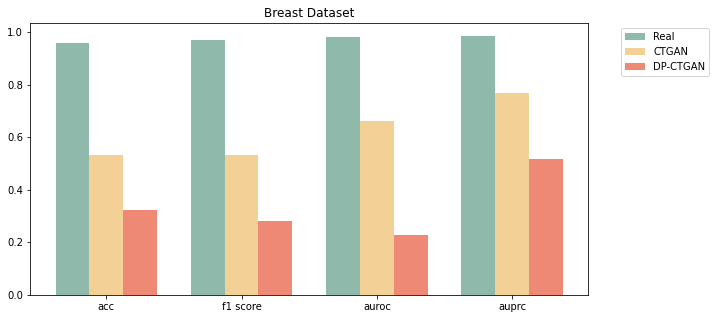

In [29]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['acc', 'f1 score', 'auroc', 'auprc']
plt.figure(figsize=(10, 5))
X = np.arange(4)
plt.title("Breast Dataset")
plt.bar(X + 0.00, trtr, width=0.25, color='#8FB9AA')
plt.bar(X + 0.25, tstr_ctgan, width=0.25, color='#F2D096')
plt.bar(X + 0.50, tstr_dpctgan, width=0.25, color='#ED8975')
plt.xticks(X + 0.25, metrics)
plt.legend(['Real', 'CTGAN', 'DP-CTGAN'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()